# Football Event's Analysis

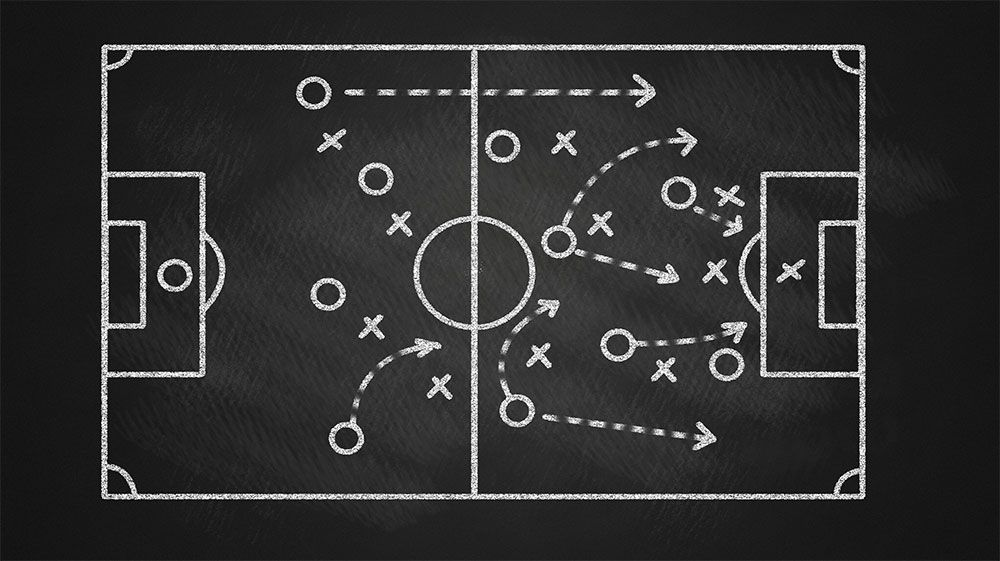

# Introduction

This dataset is a result of a very tiresome effort of webscraping and integrating different data sources from https://www.kaggle.com/secareanualin/football-events. The central element is the text commentary. All the events were derived by reverse engineering the text commentary, using regex. Using this, I was able to derive 11 types of events, as well as the main player and secondary player involved in those events and many other statistics. In case I've missed extracting some useful information, you are gladly invited to do so and share your findings. The dataset provides a granular view of 9,074 games, totaling 941,009 events from the biggest 5 European football (soccer) leagues: England, Spain, Germany, Italy, France from 2011/2012 season to 2016/2017. There are games that have been played during these seasons for which I could not collect detailed data. Overall, over 90% of the played games during these seasons have event data.

In this report, I am going to take a look at statistics from football matches in the past six years (2011-2017), and try to come up with some interesting findings. This dataset includes information on 9,074 matches from Europe’s top five leagues: the Premier League, La Liga, Serie A, Bundesliga, and Ligue 1. So without further ado, lets dive straight into the analysis!

The Objective is :
1. Data Exploration in event 90 minutes in field

2. Data Exploration Teams & Players in 5 years period

3. xG Model (Expected Goals Model)

4. Conclusions about xG Model

## Data Preparation

In [1]:
# Prepare the packages !

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns

from dtreeviz.trees import dtreeviz
from IPython.display import Image
from six import StringIO
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
# Import the data sets
data=pd.read_csv('dataset/events.csv', sep=',',header=0)

# Lets see the data shape
print("Dataset shape :", data.shape)

Dataset shape : (941009, 22)


In [3]:
# Lets see the data info
data.info()

# Lets see the data head & tail
display(data.head())
display(data.tail())

# Lets describe the data
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
941004,z5L2OT5E/,z5L2OT5E123,123,92,Lucas Torreira (Sampdoria) wins a free kick in...,8,NaN,2,Sampdoria,Atalanta,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
941005,z5L2OT5E/,z5L2OT5E124,124,93,"Corner, Sampdoria. Conceded by Andrea Masiello.",2,NaN,2,Sampdoria,Atalanta,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
941006,z5L2OT5E/,z5L2OT5E125,125,93,Attempt missed. Fabio Quagliarella (Sampdoria)...,1,12.0,2,Sampdoria,Atalanta,...,NaN,NaN,8.0,2.0,0,9.0,1.0,1,3.0,0
941007,z5L2OT5E/,z5L2OT5E126,126,94,Alberto Grassi (Atalanta) wins a free kick on ...,8,NaN,1,Atalanta,Sampdoria,...,NaN,NaN,NaN,NaN,0,4.0,NaN,0,NaN,0
941008,z5L2OT5E/,z5L2OT5E127,127,94,Foul by Pedro Pereira (Sampdoria).,3,NaN,2,Sampdoria,Atalanta,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0


,sort_order,time,event_type,event_type2,side,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
count,941009.000000,941009.000000,941009.000000,214293.000000,941009.000000,227459.000000,228498.000000,941009.000000,467067.000000,229185.000000,941009.000000,229137.000000,941009.000000
mean,53.858826,49.663663,4.326575,12.233764,1.481170,5.733693,1.926555,0.025978,6.209073,1.624831,0.264332,1.281316,0.004876
std,32.014268,26.488977,2.995313,0.468850,0.499646,3.326100,0.797055,0.159071,5.421736,0.740400,0.655501,0.709394,0.069655
min,1.000000,0.000000,1.000000,12.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,27.000000,27.000000,2.000000,12.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000
50%,53.000000,51.000000,3.000000,12.000000,1.000000,5.000000,2.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000
75%,79.000000,73.000000,8.000000,12.000000,2.000000,9.000000,3.000000,0.000000,11.000000,2.000000,0.000000,1.000000,0.000000
max,180.000000,100.000000,11.000000,15.000000,2.000000,13.000000,4.000000,1.000000,19.000000,3.000000,4.000000,4.000000,1.000000


# The Event 90 Minutes

What events happen in the soccer field for 90 minutes? 
Here's a very informative summary of the Exploratory Data Analaysis !

In [4]:
# Lets the processsing data goal, if goals the value is 1

goals=data[data["is_goal"]==1]

### Analysing goals against Time

Text(0.5, 1.0, 'Number of goals against Time during match')

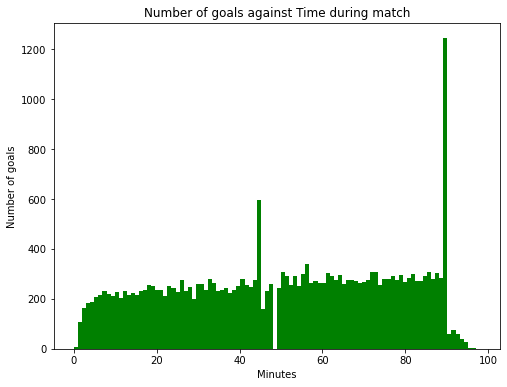

In [5]:
# Crate the plot

fig=plt.figure(figsize=(8,6))
plt.hist(goals.time,width=1,bins=100,color="green")   #100 so 1 bar per minute
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.title("Number of goals against Time during match")

The plot above shows :

  Most goals are scored around the Half-Time (45mins + extra time) and around Full-Time (90mins + extra time)

### Analysing Home/Away goals

Text(0.5, 1.0, 'Number of goals (by home/away side) against Time during match')

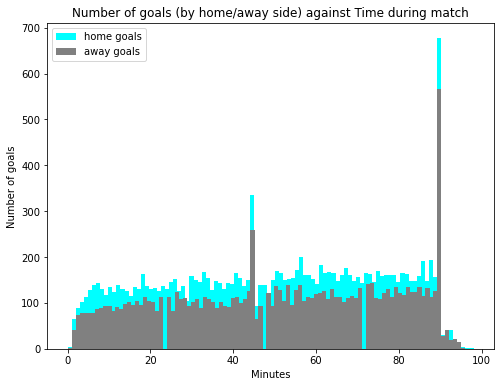

In [6]:
# Crate the Plot
# side 1 = home, side 2 = away

fig=plt.figure(figsize=(8,6))
plt.hist(goals[goals["side"]==1]["time"],width=1,bins=100,color="cyan",label="home goals")   
plt.hist(goals[goals["side"]==2]["time"],width=1,bins=100,color="grey",label="away goals") 
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.legend()
plt.title("Number of goals (by home/away side) against Time during match")



The plot above shows:

For every minute, most of the goals scored are by the home side. This supports the general notion that the home side has a statistical advantage. 


### Analysing HOW and WHERE goals are scored

findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.


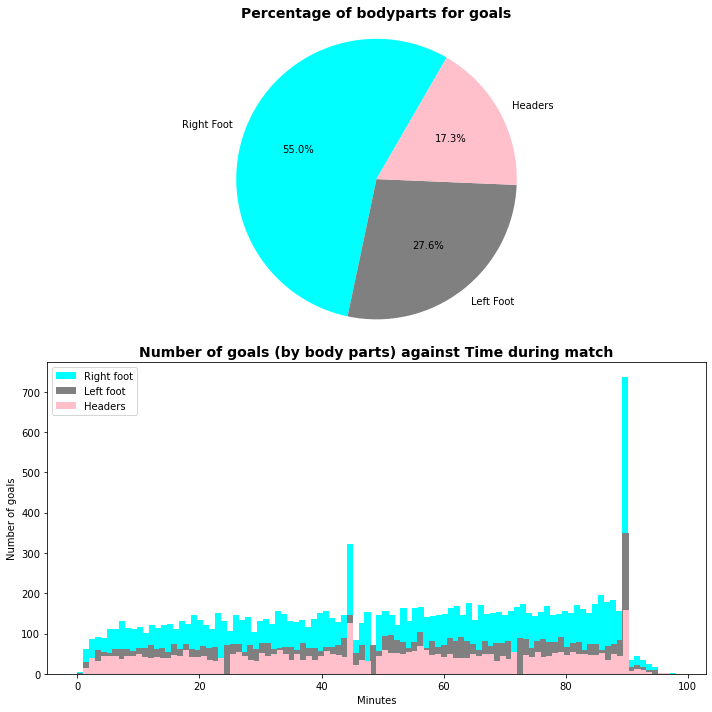

In [7]:
# Create the plot
# bodypart 1 = right foot, bodypart 2 = left foot, bodypart 3 = header

plt.subplot(2,1,1)
labels=["Right Foot","Left Foot","Headers"]
sizes=[goals[goals["bodypart"]==1].shape[0],
       goals[goals["bodypart"]==2].shape[0],
       goals[goals["bodypart"]==3].shape[0]]
colors=["cyan","grey","pink"]
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=60)
plt.axis('equal')
plt.title("Percentage of bodyparts for goals",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
fig=plt.gcf() 
fig.set_size_inches(10,10)


plt.subplot(2,1,2)
plt.hist(goals[goals["bodypart"]==1]["time"],width=1,bins=100,color="cyan",label="Right foot")   
plt.hist(goals[goals["bodypart"]==2]["time"],width=1,bins=100,color="grey",label="Left foot") 
plt.hist(goals[goals["bodypart"]==3]["time"],width=1,bins=100,color="pink",label="Headers") 
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.legend()
plt.title("Number of goals (by body parts) against Time during match",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
plt.tight_layout()



The plots above shows:

   Most of the goals (slightly more than half) scored are by Right Footed, followed by Left Footed and lastly, by Headers.

Perhaps this might be because the majority of humans are right-footed and hence, most players are right-footed. Such as Cristiano Ronaldo, Zlatan Ibrahimovic, Karim Benzema, etc. It is also not surprising that most goals have been scored by foot not head, as after all, soccer is meant to be played by foot.


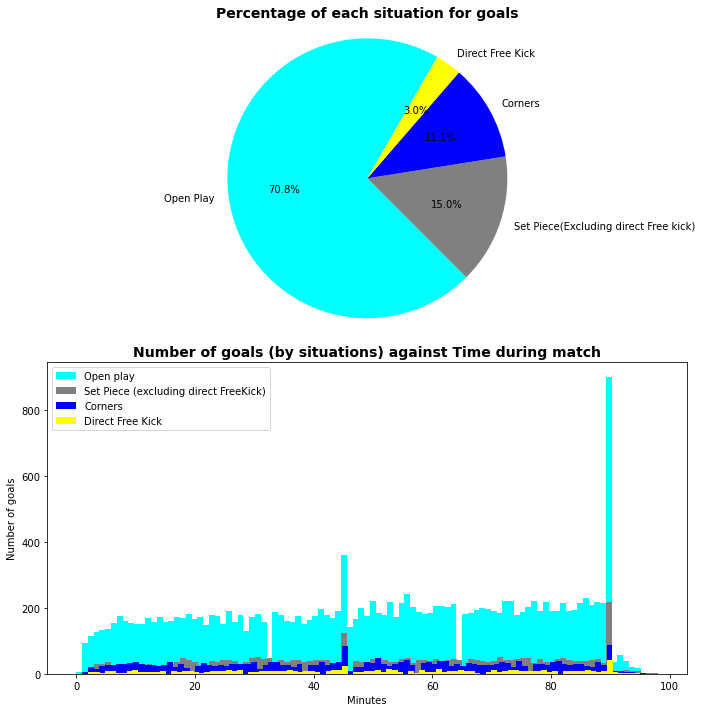

In [8]:
# Create the plot

plt.subplot(2,1,1)
labels=["Open Play", "Set Piece(Excluding direct Free kick)","Corners","Direct Free Kick"]
sizes=[goals[goals["situation"]==1].shape[0],
       goals[goals["situation"]==2].shape[0],
       goals[goals["situation"]==3].shape[0],
       goals[goals["situation"]==4].shape[0]]
colors=["cyan","grey","blue","yellow"]
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=60)
plt.axis('equal')
plt.title("Percentage of each situation for goals",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
fig=plt.gcf() 
fig.set_size_inches(10,10)

plt.subplot(2,1,2)
plt.hist(goals[goals["situation"]==1]["time"],width=1,bins=100,color="cyan",label="Open play")   
plt.hist(goals[goals["situation"]==2]["time"],width=1,bins=100,color="grey",label="Set Piece (excluding direct FreeKick)") 
plt.hist(goals[goals["situation"]==3]["time"],width=1,bins=100,color="blue",label="Corners") 
plt.hist(goals[goals["situation"]==4]["time"],width=1,bins=100,color="yellow",label="Direct Free Kick") 
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.legend()
plt.title("Number of goals (by situations) against Time during match",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
plt.tight_layout()



The plots show:

About 70.8% of the goals scored are from open play. The modern football very determined the offensive attempt. Barcelona's Tiki-taka is very beautiful tactics in decade 2010.

We now check for which "locations" that did not result in a goal so we would not need to include them in our analysis.


In [9]:
# Lets create new classification for the plot

for i in range(20):
    if sum(goals["location"]==i)==0:
        print(i)

0
1
2
4
5


Create the new class Location :

A. The Difficult Angle Goals :
(6	Difficult angle and long range;
7	Difficult angle on the left;
8	Difficult angle on the right)

B. The Long Range Goals :
(16	Long range;
17	More than 35 yards;
18	More than 40 yards)

C. The Box Goals :
(3	Centre of the box;
9	Left side of the box;
11	Right side of the box;
15	Outside the box)

D. Close Range Goals :
(10	Left side of the six yard box;
12	Right side of the six yard box;
13	Very close range)

E. The Penalties Goals
(14	Penalty spot)

F. Not Recorded Goals (Own Goal, Direct Throw in, Direct Corner)
(19	Not recorded)


findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.


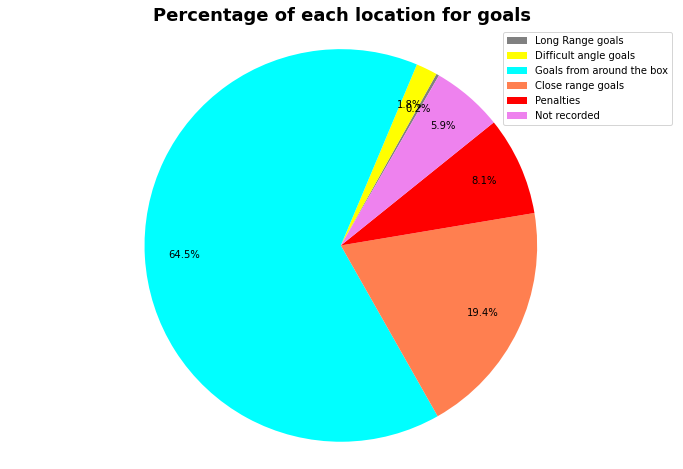

In [10]:
# Create the plot with new classification

diff_angle_goals=sum(goals["location"]==6)+sum(goals["location"]==7)+sum(goals["location"]==8)
long_range_goals=sum(goals["location"]==16)+sum(goals["location"]==17)+sum(goals["location"]==18)
box_goals=sum(goals["location"]==3)+sum(goals["location"]==9)+sum(goals["location"]==11)+sum(goals["location"]==15)
close_range_goals=sum(goals["location"]==10)+sum(goals["location"]==12)+sum(goals["location"]==13)
penalties=sum(goals["location"]==14)
not_recorded=sum(goals["location"]==19)

labels=["Long Range goals","Difficult angle goals","Goals from around the box","Close range goals","Penalties","Not recorded"]
sizes=[long_range_goals,diff_angle_goals,box_goals,close_range_goals,penalties,not_recorded]
colors=["gray","yellow","aqua","coral","red","violet"]
plt.pie(sizes,colors=colors,autopct='%1.1f%%',startangle=60,pctdistance=0.8,radius=3)
plt.axis('equal')
plt.title("Percentage of each location for goals",fontname="Times New Roman Bold",fontsize=18,fontweight="bold")
plt.legend(labels)
fig=plt.gcf() 
fig.set_size_inches(12,8)
plt.show()

### The effective of assist

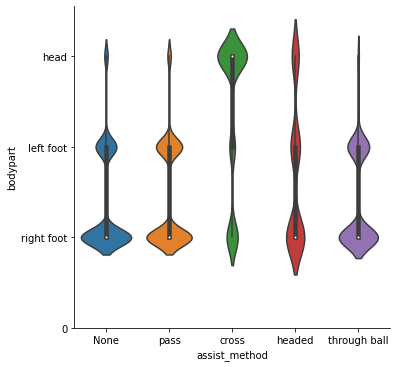

In [11]:
sns.catplot(data=data,x='assist_method', y=goals['bodypart'], kind='violin')
plt.xticks(ticks=range(5),labels=['None','pass','cross','headed','through ball'])
plt.yticks(ticks=range(4),labels=['0','right foot','left foot','head'])
plt.show()

Lets see overall the scorers with right foot except assist method with cross.

### Analysing the Cards in 90 Minutes



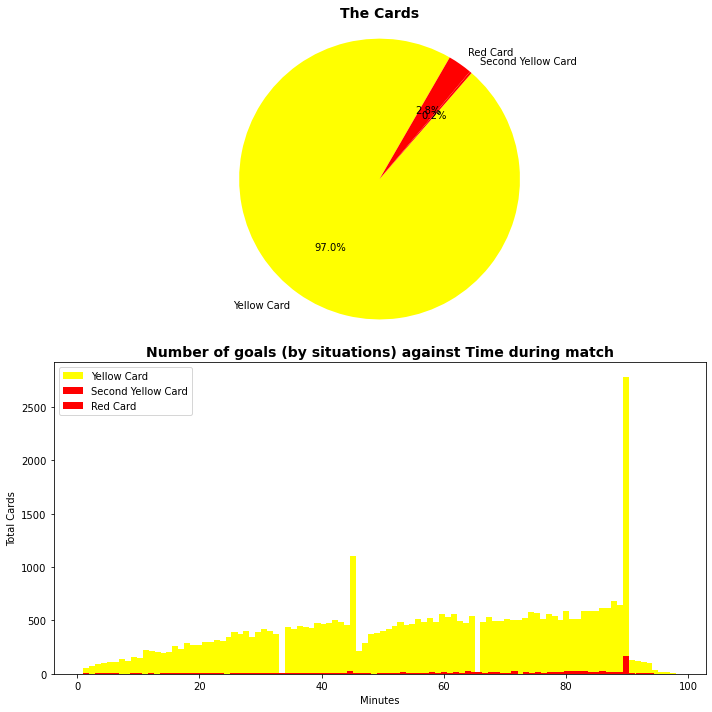

In [12]:
# Create the plot

plt.subplot(2,1,1)
labels=["Yellow Card", "Second Yellow Card","Red Card"]
sizes=[data[data["event_type"]==4].shape[0],
      data[data["event_type"]==5].shape[0],
      data[data["event_type"]==6].shape[0]]
colors=["yellow","red","red"]
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=60)
plt.axis('equal')
plt.title("The Cards",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
fig=plt.gcf() 
fig.set_size_inches(10,10)

plt.subplot(2,1,2)
plt.hist(data[data["event_type"]==4]["time"],width=1,bins=100,color="yellow",label="Yellow Card")   
plt.hist(data[data["event_type"]==5]["time"],width=1,bins=100,color="red",label="Second Yellow Card") 
plt.hist(data[data["event_type"]==6]["time"],width=1,bins=100,color="red",label="Red Card") 
plt.xlabel("Minutes")
plt.ylabel("Total Cards")
plt.legend()
plt.title("Number of goals (by situations) against Time during match",fontname="Times New Roman Bold",fontsize=14,fontweight="bold")
plt.tight_layout()

The last 5 minutes its the crucial time in football !

Tired, Lost Concentration, and a Little Careless. Then BOOM its goal for opponent

### The Correlation

<AxesSubplot:>

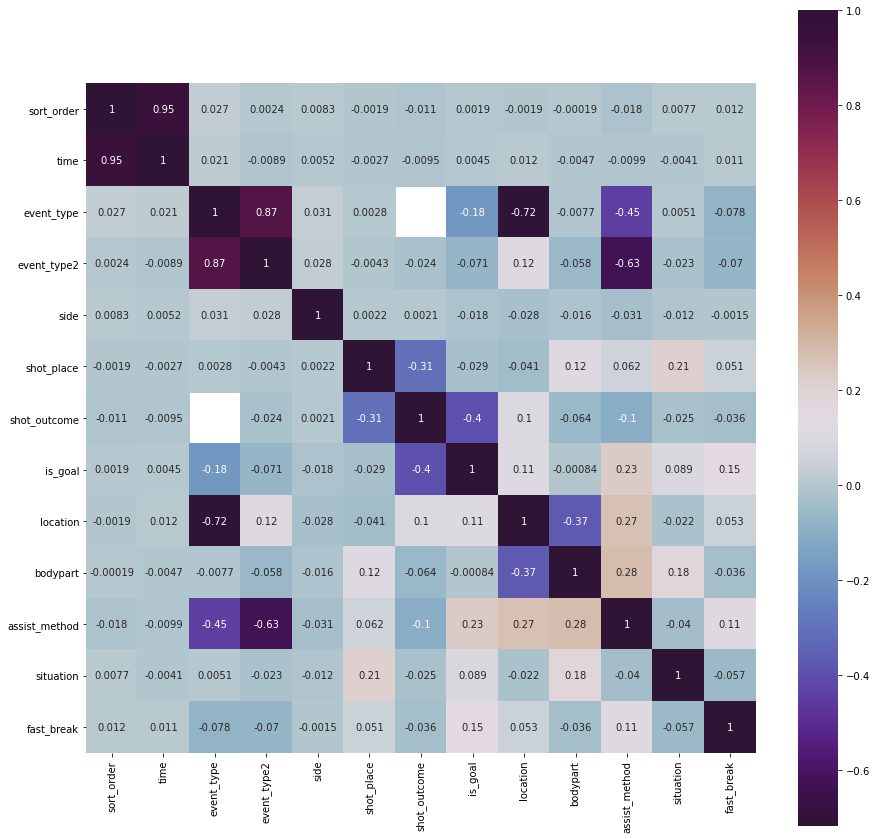

In [13]:
# Lets check the correlation all variables

plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),square=True,annot=True,cmap= 'twilight_shifted')

From the output, it can be seen that the diagonal grouping of several pairs of attributes. This indicates a high and predictable relationship.

Event type and Event type 2 are two variables that have a very high correlation, because they are closely related between these variables, and bodypart and location have a good correlation, there is an absolute limit of 0.8 (tresshold)

# The Teams & Players

After we explore the data about events in the field for 90 minutes. Now discussing the best teams and the best players during the decade of 2010. 
It is known that this decade is the era of "Ronaldo vs Messi". In this data (2012-2015) the Balon d'Or, the highest award for world football players is won by Ronaldo with 4 and 2 to Messi. Take a look at the following statistics !

### Most Scoring Goals Teams

Text(0.5, 0, 'Number of Goals')

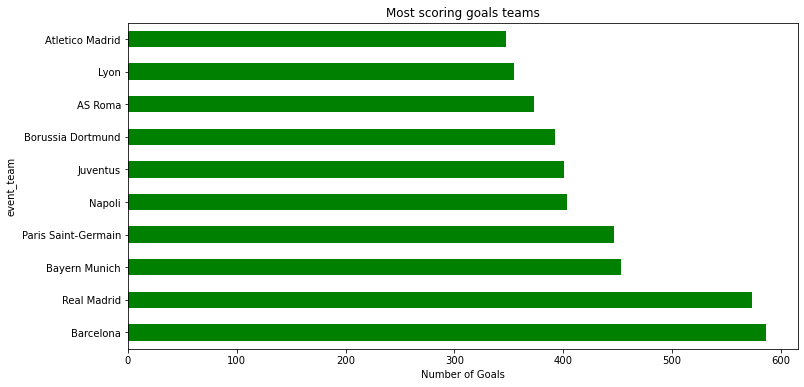

In [14]:
## Grouping attempts by team
grouping_by_offensive = data[data['is_goal']==1].groupby('event_team')

## Sorting the values
grouping_by_offensive = grouping_by_offensive.count().sort_values(by='id_event', ascending=False)[:10]
teams = grouping_by_offensive.index
scores = grouping_by_offensive['id_event']

## Plotting the teams
scores.plot(kind = 'barh', figsize = (12,6), color = 'g', title = 'Most scoring goals teams')
plt.xlabel('Number of Goals')

We can see Real Madrid and Barcelona chasing each other in total goals during this period. This is in accordance with the titles they achieved both in the domesitic league (La Liga) and winning the UEFA Champions League. 
Bayern and PSG are under the 2 Spanish giants because they are champions in their respective leagues (Germany and France). 
As well as Juventus and Napoli are actively competing in Italy. 

Fun Fact: Top 10 most goals no team from the Premier League

### Most Offensive Teams

Text(0.5, 0, 'Number of attempts')

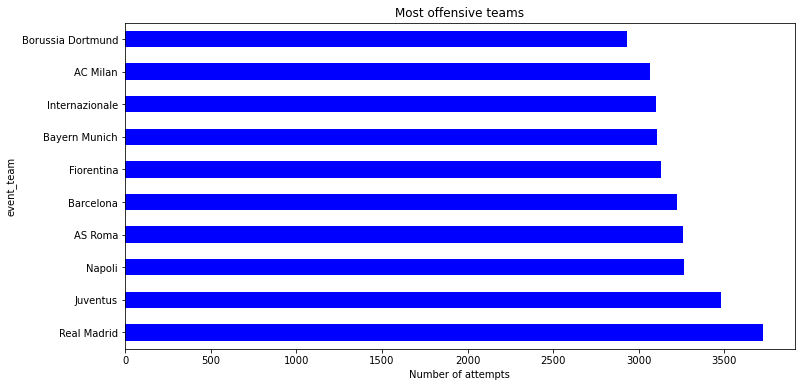

In [15]:
## Grouping attempts by team
grouping_by_offensive = data[data['event_type']==1].groupby('event_team')

## Sorting the values
grouping_by_offensive = grouping_by_offensive.count().sort_values(by='id_event', ascending=False)[:10]
teams = grouping_by_offensive.index
scores = grouping_by_offensive['id_event']

## Plotting the teams
scores.plot(kind = 'barh', figsize = (12,6), color = 'b', title = 'Most offensive teams')
plt.xlabel('Number of attempts')

Effective attacks produce goals that are classy. 
That's what occupied Real Madrid and Juventus had the most attempts during that period. 
The result is 3 Champions League titles that Real Madrid deserve, and the results are less fortunate for Juventus. Being a champion in the Italian League, but still not able to get the highest title in Europe; lost to Barcelona (2014) and Real Madrid (2017). 

Fun Fact Serie-A teams dominate in the top 10 most attempts in that period.

### Top 10 Goal Players

Text(0.5, 0, 'Number of Goals')

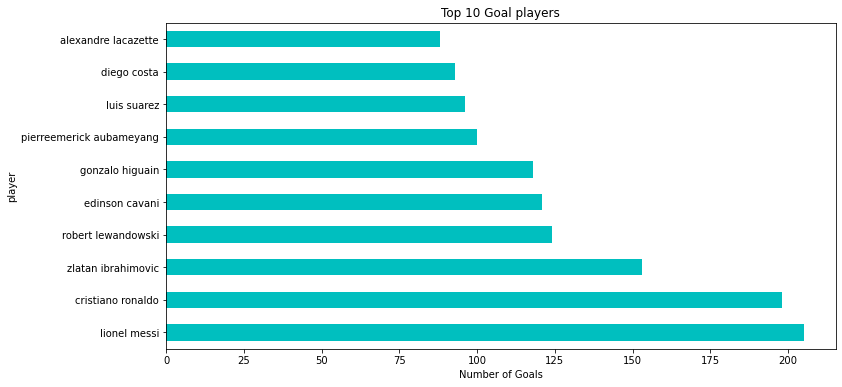

In [16]:
## grouping by player when is goal
grouping_by_offensive_player = data[data['is_goal']==1].groupby('player')

## Couting and sorting the number of goals by player, then pick the top 10
grouping_by_offensive_player = grouping_by_offensive_player.count().sort_values(by='id_event',
                                                                                ascending=False)[:10]
## Extracting player names
players = grouping_by_offensive_player.index
## Extracting values (# of goals)
scores = grouping_by_offensive_player['id_event']

## Plotting the teams
scores.plot(kind = 'barh', figsize = (12,6), color = 'c', title = 'Top 10 Goal players')
plt.xlabel('Number of Goals')

It was in this era, world football fans were presented with "the Ronaldo vs Messi" era, chasing goals often occurred in the domestic league and champions league. 
In 2014, Ronaldo was listed as the top scorer of the Champions League with a total of 17 goals and 48 goals in La Liga. 
Meanwhile, Messi became the top scorer in la Liga's history in 2012 by scoring 50 Goals.

Fun Fact : Other players like Cavani have made Napoli and PSG into the team's list of most goals. Aubameyang with Borrusia Dortmund, Ibrahimovic with PSG, and Diego Costa at Atletico Madrid.

### Top 10 Assist Players

Text(0.5, 0, 'Number of Goals')

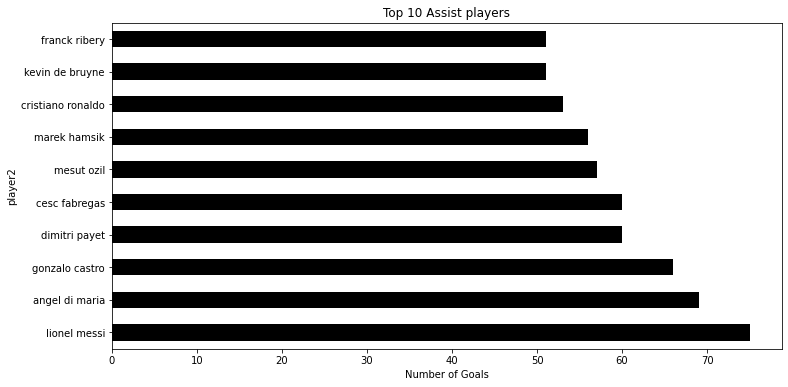

In [17]:
## Grouping data by assists
top_assists = data[(data['is_goal'] == 1) & (data['player2'] != np.nan)].groupby('player2').count().sort_values('id_event', ascending=False)[:10]

## Extracting player names
players = top_assists.index

## Extracting values (# of goals)
scores = top_assists['id_event']

## Plotting the teams
scores.plot(kind = 'barh', figsize = (12,6), color = 'k', title = 'Top 10 Assist players') 
plt.xlabel('Number of Goals')

Messi became king in the decade of 2010. As an attacking midfielder, Messi is free to carry the ball and see the situation in the field skillfully. 
It was proven that not only the king of goals, Messi was able to become the king of assists in that period. 
Away with Ronaldo in 8th place, because of his position on the right wing. 
Di Maria, who played at Real Madrid, was able to become second because of the active supplier of Ronaldo and Mesut Ozil.

Fun Fact : Kevin de Brunye finally represented the English Premier League with Manchenster City with his assist

### Goal per Match Players

It's time to make change the comparison a bit, our first and most simple modification is counting the goals per match, just by dividing the number of goals over the number of matches played by that player The players that played fewer matches of quarter of the most player are excluded, in order to prevent player who played only one match with 2 goals to have 200% (minimum played 31 matches)

In [18]:
# Create Variable Goal per Match
def GPM(data):
    x=data[data['situation']!='Own goal']
    y=x.groupby(['id_odsp','player'])['is_goal'].sum().reset_index().rename(columns={'id_odsp':'Matches','is_goal':'G'})
    xy=y.groupby('player').agg({'Matches':'count','G':"sum"})
    xy['GPM']=xy['G']/xy['Matches']
    xy=xy[xy['Matches']>xy['Matches'].max()*0.25]

    xy.sort_values(by='GPM',ascending=False)
    return xy.sort_values(by='GPM',ascending=False)

player_gpm=GPM(data)
player_gpm[:20]

,Matches,G,GPM
player,,,
lionel messi,178,205,1.151685
cristiano ronaldo,177,198,1.118644
luis suarez,106,96,0.905660
zlatan ibrahimovic,171,153,0.894737
sergio aguero,95,75,0.789474
robert lewandowski,171,124,0.725146
harry kane,95,65,0.684211
edinson cavani,179,121,0.675978
gonzalo higuain,176,118,0.670455


Messi still hold the lead (good news for his fans) with about 0.04 difference between him and Cristiano, also Lewandowski 6th position, instead Luis Suarez in 3rd , New faces appeared here like Huntelaar and Neymar, they may be not involved in all matches so the number of Goals is not so high but regarding the small number of matches they participated in, maybe they have a chance to compete for the top 20.

## Data Modeling



Here we prepare the data for making it suitable as input for our xG Model. First I will talk a bit about what Expected Goals is.

Expected Goals Models are an attempt to quantify how likely it is that a certain shot results in a goal. With this metric, we can analyze what happened in a game other than how many goals each team scored. Since the game is won with goals, and goals come only from shots (except for the rare case of an own goal), then the xG metric only needs data from shots to be developed. In other words, anything else that may influence how many "expected goals" a team would score has to happen via having more shots in the first place. For example, one could argue that if team B receives 3 red cards, then team A is supposed to score more goals (an increase in expected goals). However, in reality, having 3 more players on the field will result in taking more (and possibly better) shots, and it is taking more shots that will result in an increase in expected goals. Therefore, shots and their information are the only thing we need to take into account!

I believe that an xG Model should not take into account specific characteristics or skills of the players who intervene in the event. I've read in some other places that xG models should account for this to be more accurate, but I strongly disagree. Of course that if Messi is one-on-one with the goalkeeper the chances of it being a goal are higher than with any other player. Or if Manuel Neuer is the goalkeeper then the probability of it being a goal may go down. But that is not the point of the metric. We are trying to standardize through thousands of datapoints how likely it is that any given player would score from a certain position in a certain situation. If the player is an extraordinary finisher, then he will probably score more goals than expected, and that's fine. If we start taking into account the skills of the players involved, it is my opinion that we would be taking one step too far towards the design of this metric and would become less meaningful.

After this (long) introduction, let's prepare X and Y sets. Y will simply include every shot in the database and whether it was a goal or not (1 or 0). It is our target variable. X will include all the relevant information about the shot that we have in our data. That would be:

A. location: attacking half, defensive half, centre of the box, left wing, right wing, difficult angle and long range, difficult angle on the left, difficult angle on the right, left side of the box, left side of the six yard box, right side of the box, right side of the six yard box, very close range, penalty spot, outside the box, long range, more than 35 yards, more than 40 yards, not recorded.

B. bodypart: right foot, left foot, head.

C. assist_method: none, pass, cross, headed pass, through ball.

D. situation: open play, set piece, corner, free kick.

E. fast_break: 1 or 0, whether the shot comes from a fast break or not.

So, we have a lot of meaningful information about every shot. The location from which it was taken, which part of the body was used for shooting, how the shoot was made available (after a pass? a cross? etc.), and the situation or context in which the shoot occured (open play, corner, etc.)

Since all of these are categorical variables, we have to convert them to binary dummies (except for fast_break, which is already binary).

In [19]:
#as we only focus on shots for this analysis, 
#let's create another dataframe that only keeps the shot events
data_shot = data[data.event_type == 1]

In [20]:
print ('Number of shots not located : ', data_shot.is_goal[data.location == 19].count()) 
print ('Split by goal or no goal : ', data_shot.is_goal[data.location == 19].value_counts()) 
print('\
      ')
print('Number of shot recorded', data_shot.is_goal.count())

Number of shots not located :  1450
Split by goal or no goal :  1    1438
0      12
Name: is_goal, dtype: int64
      
Number of shot recorded 229135


We are going to drop those N/A values for the shot location, as they represent less than 6% of the goals. Unfortunately almost all of them are goals, but we should have enough data.

Of course, at the end some players will see their number of goals decresead, but we judge it acceptable.

First of all, we saw that some shot locations are not recorded (location == 19). Let's check if there is a lot of these N/A values or not.

In [21]:
data_shot = data_shot[data_shot.location != 19]

In [22]:
data_shot.count()

id_odsp          227685
id_event         227685
sort_order       227685
time             227685
text             227685
event_type       227685
event_type2      167859
side             227685
event_team       227685
opponent         227685
player           227684
player2          167798
player_in             0
player_out            0
shot_place       226677
shot_outcome     227685
is_goal          227685
location         227685
bodypart         227685
assist_method    227685
situation        227685
fast_break       227685
dtype: int64

In the features that are interesting for us, we have no NaN or undefined values, so we can keep on going.

In [23]:
print(len(data_shot))
print(data_shot.is_goal.sum())
print(len(data_shot.columns)-1)

227685
23003
21


So we have a total of 227.685 shots, of which 23.003 were goals. For each shot, we have 22 different characteristics that describe it. All of these 22 characteristics are binary, so they just indicate Yes or No to a certain characteristics in the shot.

Now we will divide our X and y into two different sets for training and testing. I will use 75% of them for training our model and 25% por testing it. This is because we have enough datapoints, so 75% should be enough to train it properly and I'd rather have as many shots left as possible for pure testing later.

X/Y variables definition and train/test split

Here we pick our explanatory variables. The output, obviously, will be if the shot ends in the back of the net or not.

In [24]:
X = data_shot[['bodypart', 'location', 'situation', 'assist_method', 'fast_break']]
y = data_shot['is_goal']

In [25]:
# Create the All Classification Model of Machine Learning

classifiers = [
    LogisticRegression(solver="liblinear"),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
              ]

In [26]:
# Create the Method 

def train_model(X, y, model, test_size=.25):
    X_train, X_dev, y_train, y_dev = train_test_split(
        X, y, test_size=test_size, random_state=99
    )
    print(f"Training with {X_train.shape[0]} data.. Validating with {X_dev.shape[0]}..")

    start = time()
    model.fit(X_train, y_train)
    end = time()
    print(f"Done training {model.__class__.__name__} in {end-start:.3f}s")
    
    train_prediction = model.predict(X_train)
    dev_prediction = model.predict(X_dev)
    Score = metrics.accuracy_score(y_dev, dev_prediction)
    
    print("Confusion Matrix")
    print(confusion_matrix(y_dev, dev_prediction))
    
    print("Training performance:")
    print(classification_report(y_train, train_prediction))

    print("Development performance:")
    print(classification_report(y_dev, dev_prediction))
    
    print('Accuracy Score: %.5f' % Score)

## Visualize 1 models

### Random Forest

In [27]:
model = RandomForestClassifier()
train_model(X, y, model)

Feature_importance = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
Feature_importance

Training with 170763 data.. Validating with 56922..
Done training RandomForestClassifier in 11.689s
Confusion Matrix
[[50544   671]
 [ 4457  1250]]
Training performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    153467
           1       0.67      0.22      0.34     17296

    accuracy                           0.91    170763
   macro avg       0.80      0.61      0.64    170763
weighted avg       0.89      0.91      0.89    170763

Development performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     51215
           1       0.65      0.22      0.33      5707

    accuracy                           0.91     56922
   macro avg       0.78      0.60      0.64     56922
weighted avg       0.89      0.91      0.89     56922

Accuracy Score: 0.90991


location         0.695999
assist_method    0.100424
situation        0.085803
fast_break       0.078118
bodypart         0.039657
dtype: float64

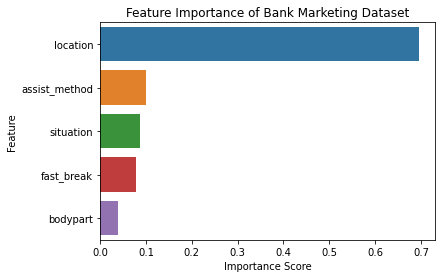

In [28]:
sns.barplot(x=Feature_importance, y=Feature_importance.index)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance of Bank Marketing Dataset")
plt.show()

## Comparing All ML-Model

In [29]:
# Run the model

for model in classifiers:
    print(f"=== Using {model.__class__.__name__} ===")
    train_model(X, y, model)

=== Using LogisticRegression ===
Training with 170763 data.. Validating with 56922..
Done training LogisticRegression in 1.002s
Confusion Matrix
[[51189    26]
 [ 5658    49]]
Training performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    153467
           1       0.60      0.01      0.02     17296

    accuracy                           0.90    170763
   macro avg       0.75      0.50      0.48    170763
weighted avg       0.87      0.90      0.85    170763

Development performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     51215
           1       0.65      0.01      0.02      5707

    accuracy                           0.90     56922
   macro avg       0.78      0.50      0.48     56922
weighted avg       0.88      0.90      0.85     56922

Accuracy Score: 0.90014
=== Using KNeighborsClassifier ===
Training with 170763 data.. Validating with 56922..
Done trainin

It seems that the Gradient Boosting is the best technique in our case.

We should try to tune the hyperparameters to improve its accuracy, but as I'm not super comfortable with Gradient Boosting tuning for now, it won't be in this version. We get an accuracy around 91% for our model. But is that good or bad? We need to establish some baselines to judge.

In [30]:
data_shot.is_goal.value_counts()

0    204682
1     23003
Name: is_goal, dtype: int64

In fact, the 91% accuracy is not that good, as we can reach a 89.9% accuracy if we say that all the shots resulted in no goal.
The most relevant in our case will be to predict the most frequent occurence (no goal), as our dataset is unbalanced.
But we will have to keep this model for now, as we don't really have options to improve it.

#### Give a value to each shot

The purpose of our model is to give a value to each shot. To do so, we are going to use the probability of a given shot to turn into a goal.

This can be found by using the predict_proba method on our dataset.

In [31]:
# add the probability to get 1 for every row as a new column
probas = model.predict_proba(X)
data_shot['xgoalpercent'] = probas[:,1] 

In [32]:
print('Maximum xG value for a shot : ', probas[:,1].max())
print('Minimum xG value for a shot : ', probas[:,1].min())

Maximum xG value for a shot :  0.8855330072545706
Minimum xG value for a shot :  0.00345617269988209


count    227685.000000
mean          0.101374
std           0.129594
min           0.003456
25%           0.028467
50%           0.058259
75%           0.131511
max           0.885533
Name: xgoalpercent, dtype: float64

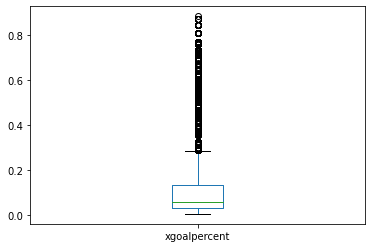

In [33]:
# Statistics Descriptive the Expected Goals

data_shot.xgoalpercent.plot(kind="box")
data_shot.xgoalpercent.describe()

##### Analysis Expected Goals

Expected data Goals are well known in the 0.1 range because of the factors played in that period and the number of goals. It seems that the outliers data is spread because the number of players who play a little, for example <10 plays, but is able to score goals during that period.

### Conclusions about xG Model

We will choice a Gradient Boosting Classifier, which is a very powerful algorithm. It consists of an ensemble of decision trees. Because these trees tend to overfit to the training data, developing thousands of different trees making use of different predictors and samples each time helps us reduce the variance of our predictions within the famous bias vs variance tradeoff.

In [34]:
model_final = GradientBoostingClassifier()
train_model(X, y, model_final)

Training with 170763 data.. Validating with 56922..
Done training GradientBoostingClassifier in 11.675s
Confusion Matrix
[[50561   654]
 [ 4469  1238]]
Training performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    153467
           1       0.67      0.22      0.33     17296

    accuracy                           0.91    170763
   macro avg       0.79      0.60      0.64    170763
weighted avg       0.89      0.91      0.89    170763

Development performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     51215
           1       0.65      0.22      0.33      5707

    accuracy                           0.91     56922
   macro avg       0.79      0.60      0.64     56922
weighted avg       0.89      0.91      0.89     56922

Accuracy Score: 0.91000


The confusion matrix summarizes all predictions. It tells us that, from all the shots that were not goal, our model correctly identified 50561 as no-goals, and made a mistake in 4469 cases in which it predicted that the shot would not be a goal, but it was. From the other column, we see that it correctly predicted 654 goals, but failed to predict 1238 succesful shots as goals.

From the report we can see the model has excellent numbers when it comes to predict class 0 (no-goal), but not that good for predicting class 1 (goals). With the latter, we have a precision of 65%, and a recall of 22%, resulting in an F1 score of 0.33. These are decent numbers, but not really good.

Does this make sense? Of course it does. Predicting whether a shot will be goal and being right is extremely more difficult than correctly predicting it will not be a goal. This is particularly true if you have no idea who the player shooting the ball is or who the goalkeeper is, which is the situation in which the algorithm is in. It would be interesting to make a human vs. machine study on this. Are human experts much better in judging whether any given shot will become a goal than a model such as this one is?


### Summary Final Projcet

The Summary is :

1. Data Exploration in event 90 minutes in field

90 minutes of normal time in a soccer match, presenting lots of moments that are a pity to miss for football connoisseurs. Of the many goals created in the final minutes of the match, the home team is always favored in scoring goals, then there are locations and parts of the body that are often used to score goals (of course the right foot), until the loss of player concentration during the last 5 minutes that makes the player commit a foul and get a card.


2. Data Exploration Teams & Players in 5 years period

In the 2010s, football focused on 2 high rivals, namely Cristiano Ronaldo and Lionel Messi. During that 5 year period, goals and trophies both nationally, club and individually were always focused on the two players. So that statistics record, each of them is chasing in the number of goals and assists, so that the team he defends has always been iconic in world football. of course, Real Madrid and Barcelona


3. xG Model (Expected Goals Model)

Expected Goals Models are an attempt to quantify how likely it is that a certain shot results in a goal. With this metric, we can analyze what happened in a game other than how many goals each team scored. Since the game is won with goals, and goals come only from shots (except for the rare case of an own goal), then the xG metric only needs data from shots to be developed. 


4. Conclusions about xG Model

We will choice a Gradient Boosting Classifier, which is a very powerful algorithm. It consists of an ensemble of decision trees. Because these trees tend to overfit to the training data, developing thousands of different trees making use of different predictors and samples each time helps us reduce the variance of our predictions within the famous bias vs variance tradeoff.